In [1]:
from azureml.core import Workspace, Experiment
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score,accuracy_score,f1_score,classification_report,precision_recall_curve,confusion_matrix,roc_auc_score,precision_score, recall_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from sklearn.externals import joblib
import sys

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer

In [3]:
ws = Workspace.from_config()

n_estimators = 10

In [4]:
experiment = Experiment(ws, 'churn-classifier')


run =  experiment.start_logging()
run.tag("python version", sys.version[0:6])
run.log('n_estimators', n_estimators)

train = pd.read_csv("data/churn.csv")

X = train.drop('Exited', axis=1)
y = train['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

rf = RandomForestClassifier(n_estimators=n_estimators)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('precprocessor', preprocessor),
    ('classifier', rf)
])

In [6]:
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
train_probs = model.predict_proba(X_train)[:,1] 
probs = model.predict_proba(X_test)[:, 1]
train_predictions = model.predict(X_train)

In [7]:
run.log("accuracy",accuracy_score(y_test, y_pred))
run.log("auc",roc_auc_score(y_test, probs))

In [8]:
import matplotlib.pyplot as plt
def evaluate_model(y_pred, probs,train_predictions, train_probs):
    baseline = {}
    baseline['recall']=recall_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test,
                    [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train,       train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)

    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    run.log_image('ROC', path=None, plot=plt, description='ROC Curve')
    plt.show();

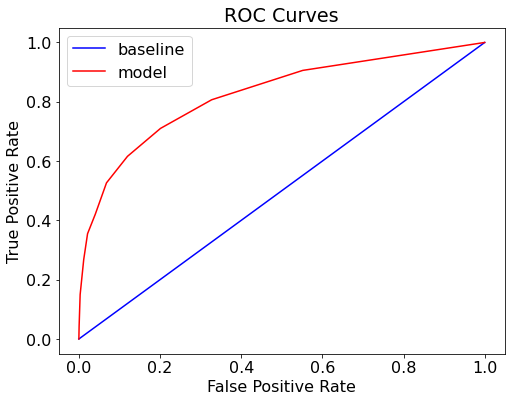

In [9]:
evaluate_model(y_pred,probs,train_predictions,train_probs)

In [10]:
model_file_name = 'outputs/model.pkl'

joblib.dump(value = model, filename = model_file_name)
run.complete()